<a href="https://colab.research.google.com/github/nikita-resh/StyleGAN-NADA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install Ninja

import torch
import matplotlib.pyplot as plt
import gdown
import clip
import gc
import time
from PIL import Image
import os
import numpy as np
from torchvision import transforms

!git clone https://github.com/rosinality/stylegan2-pytorch.git
%cd stylegan2-pytorch
from model import Generator


file_path = "/content/stylegan2-pytorch/lpips/__init__.py"
# Read file content
with open(file_path, "r") as file:
    lines = file.readlines()
# Write updated content
with open(file_path, "w") as file:
    file.writelines("from skimage.metrics import structural_similarity\n" if "compare_ssim" in line else line for line in lines)


file_path = "/content/encoder4editing/utils/alignment.py"

# Read file content
with open(file_path, "r") as file:
    lines = file.readlines()

# Replace 'PIL.Image.ANTIALIAS' with 'PIL.Image.LANCZOS' in each line
updated_lines = [line.replace('PIL.Image.ANTIALIAS', 'PIL.Image.LANCZOS') for line in lines]

# Write updated content back to the file
with open(file_path, "w") as file:
    file.writelines(updated_lines)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# download wights for stylegan2-ffhq
gdown.download("https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT", "stylegan2-ffhq-config-f.pt", quiet=False)

%cd ..
!git clone https://github.com/omertov/encoder4editing.git
%cd encoder4editing

from models.psp import pSp
from argparse import Namespace

# download wights for e4e-ffhq
gdown.download("https://drive.google.com/uc?id=1cUv_reLE6k3604or78EranS7XzuVMWeO", "e4e_ffhq_encode.pt", quiet=False)

from utils.common import tensor2im

### Initialize losses

- CLIPLoss
- CLIPDirectionalLoss

In [ ]:
class CLIPLoss(torch.nn.Module):
    def __init__(self, stylegan_size=1024):
        super(CLIPLoss, self).__init__()

        clip_weights = "ViT-B/32" #@param['ViT-B/32', 'ViT-B/16']
        self.model, self.preprocess = clip.load("ViT-B/32", device=device)

        # clip only supports images 224*224.
        # we need to resize image with min information loss possible. therefore we firstly apply upsamling, and then pooling.
        # scale_factor=7 allows not to deal with decimals
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=(1024 * 7 // 224))

    def forward(self, prompt, image):
        # text preprocessing
        tokenized_prompt = clip.tokenize([prompt]).to(device)
        # image preprocessing
        preprocessed_image = self.avg_pool(self.upsample(image))
        # encoding to CLIP space
        text_features = self.model.encode_text(tokenized_prompt)  # Remove .detach()
        image_features = self.model.encode_image(preprocessed_image)  # Remove .detach()

        # normalize embeddings
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        similarity = (image_features * text_features).sum(dim=1)
        loss = 1 - similarity.mean()

        return loss


class CLIPDirectionalLoss(torch.nn.Module):
    def __init__(self, stylegan_size=1024):
        super(CLIPDirectionalLoss, self).__init__()

        self.model, self.preprocess = clip.load("ViT-B/32", device=device)

        # clip only supports images 224*224.
        # we need to resize image with min information loss possible. therefore we firstly apply upsamling, and then pooling.
        # scale_factor=7 allows not to deal with decimals
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=(1024 * 7 // 224))

    def forward(
        self,
        frozen_generator_image,
        trainable_generator_image,
        source_prompt,
        target_prompt,
    ):
        # text preprocessing
        tokenized_source_prompt = clip.tokenize([source_prompt]).to(device)
        tokenized_target_prompt = clip.tokenize([target_prompt]).to(device)
        # image preprocessing
        preprocessed_frozen_generator_image = self.avg_pool(
            self.upsample(frozen_generator_image)
        )
        preprocessed_trainable_generator_image = self.avg_pool(
            self.upsample(trainable_generator_image)
        )

        # encoding to CLIP space
        source_prompt_features = self.model.encode_text(tokenized_source_prompt)
        target_prompt_features = self.model.encode_text(tokenized_target_prompt)
        frozen_generator_image_features = self.model.encode_image(
            preprocessed_frozen_generator_image
        )
        trainable_generator_image_features = self.model.encode_image(
            preprocessed_trainable_generator_image
        )

        delta_t = target_prompt_features - source_prompt_features
        delta_i = trainable_generator_image_features - frozen_generator_image_features

        # normalize deltas
        delta_i = delta_i / delta_i.norm(dim=1, keepdim=True)
        delta_t = delta_t / delta_t.norm(dim=1, keepdim=True)

        loss = 1 - (delta_i * delta_t).sum(dim=1).mean()

        return loss

clip_loss = CLIPLoss()
clip_directional_loss = CLIPDirectionalLoss()

In [ ]:
# Параметры генератора
size = 1024  # Размер изображения
latent_dim = 512  # Размер латентного пространства
n_mlp = 8  # Количество слоев MLP
channel_multiplier = 2
ckpt = "/content/stylegan2-pytorch/stylegan2-ffhq-config-f.pt"  # Путь к весам StyleGAN2

In [ ]:
frozen_generator = Generator(
    size, latent_dim, n_mlp, channel_multiplier=channel_multiplier
).to(device)
trainable_generator = Generator(
    size, latent_dim, n_mlp, channel_multiplier=channel_multiplier
).to(device)

frozen_generator.eval()
trainable_generator.train()

checkpoint = torch.load(ckpt)

frozen_generator.load_state_dict(checkpoint["g_ema"])
trainable_generator.load_state_dict(checkpoint["g_ema"])

In [ ]:
def freeze_stylegan_layers(generator, selected_layers=None):
    """
    Freezes specific layers in a StyleGAN generator.

    Args:
        generator: The StyleGAN generator model.
        selected_layers: A list of indices of layers that should remain trainable.
                         If None, only Mapping Network, Affine Transformations, and ToRGB layers are frozen.
    """
    # Always freeze Mapping Network (style), ToRGB layers, and Affine Transformations
    modules_to_freeze = ["style", "to_rgb1"]

    for module in modules_to_freeze:
        if hasattr(generator, module):
            for param in getattr(generator, module).parameters():
                param.requires_grad = False

    # Freeze all ToRGB layers in the ModuleList
    if hasattr(generator, "to_rgbs"):
        for to_rgb_layer in generator.to_rgbs:
            for param in to_rgb_layer.parameters():
                param.requires_grad = False

    # If selected_layers is provided, freeze all other conv layers
    if selected_layers is not None:
        for i, conv in enumerate(generator.convs):
            if i not in selected_layers:  # Freeze layers not in the selected list
                for param in conv.parameters():
                    param.requires_grad = False
            else:
                for param in conv.parameters():
                    param.requires_grad = True

In [ ]:
%matplotlib inline

source_prompt = "photo" #@param {"type": "string"}
target_prompt = "zombie" #@param {"type": "string"}

# Number of images to use in each step
batch_size = 4 #@param {type:"slider", min:1, max:4, step:1}
num_steps = 60 #@param {type:"slider", min:20, max:600, step:10}

l2_lambda = 1.0 #@param {type:"slider", min:0, max:3, step:0.1}
clip_lambda = 2.5 #@param {type:"slider", min:0, max:3, step:0.1}
clip_directional_lambda = 1.2 #@param {type:"slider", min:0, max:3, step:0.1}
num_layers = 18

optimizer = torch.optim.Adam(trainable_generator.parameters(), lr=0.01)


def get_k_relevant_layers(generator, k, target_prompt):
    # generate random latent vectors (z-space)
    latent_z = torch.randn((batch_size, latent_dim), device=device)

    generator.eval()
    with torch.no_grad():
        # map z-space to w-space using the generator's style network
        latent_w = generator.style(latent_z).detach()

        # expand w-space vectors to w+ by repeating across layers
        latent_w_plus = latent_w.unsqueeze(1).repeat(1, num_layers, 1).detach().clone()

    # enable gradient tracking for optimization
    latent_w_plus.requires_grad_(True)

    # store initial state of w+
    initial_w_plus = latent_w_plus.clone().detach()

    # set up optimizer for w+ updates
    optimizer = torch.optim.Adam([latent_w_plus], lr=0.01)

    for _ in range(10):  # perform optimization for 10 steps
        optimizer.zero_grad()

        # generate image from current latent representation
        image, _ = generator([latent_w_plus], input_is_latent=True, randomize_noise=False)

        # compute loss based on alignment with target prompt
        loss = clip_lambda * clip_loss(target_prompt, image)

        # backpropagate and update w+ latents
        loss.backward()
        optimizer.step()

        # free memory
        del image, loss

    # compute per-layer changes in w+
    delta_w = (latent_w_plus.detach() - initial_w_plus).abs().mean(dim=(0, 2))

    # select top-k layers with the most significant changes
    relevant_layers = delta_w.topk(k).indices.tolist()
    print("Relevant layers:", relevant_layers)

    # clean up GPU memory
    gc.collect()
    torch.cuda.empty_cache()

    return relevant_layers


def generate_latents(batch_size, latent_dim, device, generator):
    latent_z = torch.randn((batch_size, latent_dim), device=device)
    latent_w = generator.style(latent_z).detach().clone()
    latent_w_plus = latent_w.unsqueeze(1).repeat(1, num_layers, 1)
    return latent_w_plus


def generate_images(generator, latent_w_plus):
    with torch.no_grad():
        images, _ = generator([latent_w_plus], input_is_latent=True, randomize_noise=False)
    return images


def compute_losses(frozen_images, trainable_images, target_prompt, source_prompt):
    l2_loss_value = torch.mean((frozen_images - trainable_images) ** 2)
    clip_loss_value = clip_loss(target_prompt, trainable_images)
    clip_directional_loss_value = clip_directional_loss(
        frozen_images, trainable_images, source_prompt, target_prompt
    )
    return l2_loss_value, clip_loss_value, clip_directional_loss_value


def log_losses(losses, l2_loss_value, clip_loss_value, clip_directional_loss_value, loss):
    losses["l2"].append(l2_loss_value.detach().item())
    losses["clip"].append(clip_loss_value.detach().item())
    losses["clip_directional"].append(clip_directional_loss_value.detach().item())
    losses["total"].append(loss.detach().item())


def visualize_images(frozen_images, trainable_images, batch_size, step, num_steps, losses):
    visualize_interval = 20 #@param {type:"slider", min:1, max:50, step:1}
    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step [{step}/{num_steps}], Loss: {losses['total'][-1]}")
        fig, axs = plt.subplots(2, batch_size, figsize=(batch_size * 4, 8))
        if batch_size == 1:
            axs = [[axs[0]], [axs[1]]]
        for i in range(batch_size):
            axs[0][i].imshow(((frozen_images.cpu().detach()[i].clip(-1, 1).permute(1, 2, 0) + 1) / 2))
            axs[0][i].set_title(f"Frozen Image {i+1}")
            axs[0][i].axis("off")
            axs[1][i].imshow(((trainable_images.cpu().detach()[i].clip(-1, 1).permute(1, 2, 0) + 1) / 2))
            axs[1][i].set_title(f"Trainable Image {i+1}")
            axs[1][i].axis("off")
        plt.tight_layout()
        plt.show()


losses = {"l2": [], "clip": [], "clip_directional": [], "total": []}

def plot_losses(losses):
    """Plots the given losses over steps in a 2x2 grid."""
    steps = range(len(losses["total"]))

    # define subplot parameters
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle("Losses Over Steps", fontsize=16)

    # define loss titles and corresponding keys
    loss_info = [
        ("L2 Loss", "l2"),
        ("CLIP Loss", "clip"),
        ("CLIP Directional", "clip_directional"),
        ("Total Loss", "total")
    ]

    # plot each loss in its respective subplot
    for ax, (title, key) in zip(axs.flat, loss_info):
        ax.plot(steps, losses[key], marker="o", label=f"{key.upper()} Loss")
        ax.set_title(title)
        ax.set_xlabel("Step")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend()

    # adjust layout and display
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

for step in range(num_steps):
    optimizer.zero_grad()

    # freeze all layers, but 5 relevant
    layer_freezing_interval = 30 #@param {type:"slider", min:10, max:100, step:10}
    trainable_layers_number = 5 #@param {type:"slider", min:2, max:18, step:1}
    if step % 20 == 0:
        k_relevant_layers = get_k_relevant_layers(trainable_generator, 5, target_prompt)
        freeze_stylegan_layers(trainable_generator, k_relevant_layers)

    # get latents from w+
    latent_w_plus = generate_latents(batch_size, latent_dim, device, frozen_generator)

    # generate images with frozen and trainable generators
    frozen_generator_images = generate_images(frozen_generator, latent_w_plus)
    trainable_generator_images = generate_images(trainable_generator, latent_w_plus)

    # get all losses
    l2_loss_value, clip_loss_value, clip_directional_loss_value = compute_losses(
        frozen_generator_images, trainable_generator_images, target_prompt, source_prompt
    )

    # evaluate total weighted loss
    loss = (
        l2_lambda * l2_loss_value
        + clip_lambda * clip_loss_value
        + clip_directional_lambda * clip_directional_loss_value
    )
    log_losses(losses, l2_loss_value, clip_loss_value, clip_directional_loss_value, loss)


    loss.backward()
    optimizer.step()

    visualize_images(frozen_generator_images, trainable_generator_images, batch_size, step, num_steps, losses)
    # display_loss_plot = True #@param {type:"boolean"}
    # if display_loss_plot == True:
    #     plot_losses(losses)

    # free memory
    del frozen_generator_images, trainable_generator_images, latent_w_plus
    torch.cuda.empty_cache()


Inversion


<ipython-input-49-3bfecf52f8ea>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location="cpu")


Loading e4e over the pSp framework from checkpoint: /content/encoder4editing/e4e_ffhq_encode.pt
Model successfully loaded!
Aligned image has shape: (256, 256)


/content/inversion/face_6.jpeg


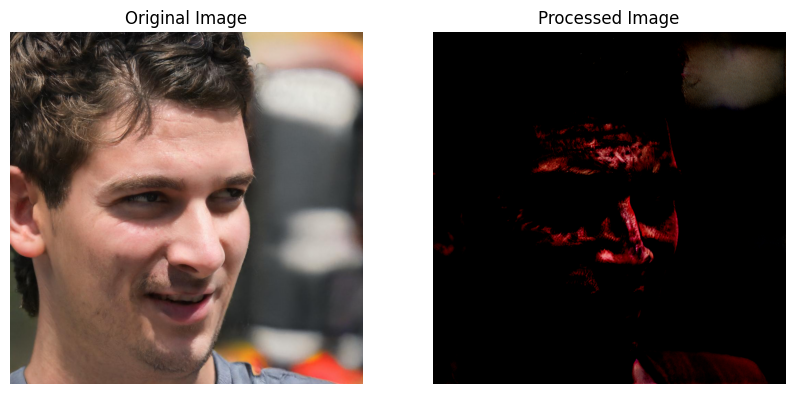

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

In [49]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from argparse import Namespace
from torchvision import transforms
import dlib
from utils.alignment import align_face  # Function for face alignment

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Load pre-trained pSp model
model_path = "/content/encoder4editing/e4e_ffhq_encode.pt"
ckpt = torch.load(model_path, map_location="cpu")
opts_dict = ckpt["opts"]
opts_dict["checkpoint_path"] = model_path  # Update checkpoint_path in the dictionary
opts = Namespace(**opts_dict)

net = pSp(opts)
net.eval()
net.to(device)
print("Model successfully loaded!")

# Directory containing images to invert
images_to_invert_dir_path = "/content/inversion" #@param {"type": "string"}

# Load face alignment model if needed
experiment_type = "ffhq_encode"
landmark_model = "shape_predictor_68_face_landmarks.dat"

if experiment_type == "ffhq_encode" and landmark_model not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

predictor = dlib.shape_predictor(landmark_model)


def run_alignment(image_path):
    """Aligns face in the image using dlib.

    Args:
        image_path (str): Path to the image file.

    Returns:
        PIL.Image: Aligned image.
    """
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print(f"Aligned image has shape: {aligned_image.size}")
    return aligned_image


def run_on_batch(inputs, model):
    """Runs the model on a batch of data.

    Args:
        inputs (torch.Tensor): Input tensor.
        model (pSp): The pSp model.

    Returns:
        tuple: Generated images and latent vectors.
    """
    images, latents = model(inputs.to(device).float(), randomize_noise=False, return_latents=True)
    return images, latents

# Process all images in the directory
for image_name in os.listdir(images_to_invert_dir_path):
    image_path = os.path.join(images_to_invert_dir_path, image_name)

    original_image = Image.open(image_path).convert("RGB")

    input_image = run_alignment(image_path) if experiment_type == "ffhq_encode" else original_image
    input_image = input_image.resize((256, 256))
    transformed_image = transform(input_image)

    with torch.no_grad():
        result_image, latent = run_on_batch(transformed_image.unsqueeze(0), net)

    trainable_generator.eval()
    trainable_generator_images, _ = trainable_generator([latent], input_is_latent=True, randomize_noise=False)

    # Plot results
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    image_np = trainable_generator_images[0].detach().cpu().permute(1, 2, 0).numpy()

    print(image_path)

    axs[0].imshow(np.asarray(original_image))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(image_np)
    axs[1].set_title("Processed Image")
    axs[1].axis("off")

    plt.show()